In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import gaussian_independent_kernel_sde, reverse, bridge
from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse

import matplotlib.pyplot as plt
import jax

In [3]:
T=1.
N=100
dim=2
num_pts = 5
alpha=0.1
sigma=1.0
grid_size = 5
grid_range = (-1, 2.)

forward_init = sample_ellipse(num_pts).flatten()
kunita_sde = gaussian_independent_kernel_sde(T, N, dim, num_pts, alpha, sigma, grid_range, grid_size)
kunita_diffusion = DiffusionBridge(kunita_sde)

In [4]:
key = jax.random.PRNGKey(2)
forward_trajs= kunita_sde.simulate_trajectories(forward_init, 2, key)

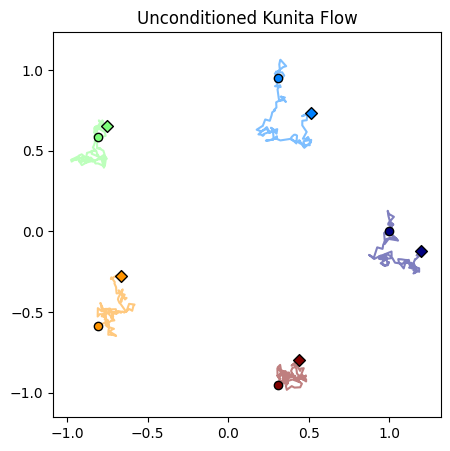

In [5]:
from sdebridge.plotting import plot_single_trajectory

traj = forward_trajs[0].reshape(-1, num_pts*dim)
plot_single_trajectory(traj, "Unconditioned Kunita Flow")

In [6]:
from sdebridge.networks.score_unet import ScoreUNet
setup_params = {
    "neural_net": ScoreUNet,
 
    "network": {
        "output_dim": kunita_diffusion.sde.dim*kunita_diffusion.sde.n_bases,
        "time_embedding_dim": 32,
        "init_embedding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [64, 32, 16, 8],
        "decoder_layer_dims": [8, 16, 32, 64],
        "batchnorm": True,
    },
    
    "training": {
        "batch_size": 100,
        "load_size": 1000,
        "num_epochs": 50,
        "num_batches_per_epoch": 10,
        "learning_rate": 5e-3,
        "warmup_steps": 0,
    }
}

target = sample_ellipse(num_pts).flatten()
train_key = jax.random.split(key, 2)[0]
score_state_p = kunita_diffusion.learn_p_score(target, train_key, setup_params)

Training: 100%|██████████| 50/50 [00:59<00:00,  1.19s/epoch, Epoch=50, loss=4.7994]


In [12]:
initial_val = sample_ellipse(num_pts, scale=1.2).flatten()
score_p = score_fn(score_state_p)
reverse_sde = reverse(kunita_sde, score_p)
backward_trajs = reverse_sde.simulate_trajectories(initial_val, 2, train_key)


In [13]:
plt_init = target.reshape((-1, 2))

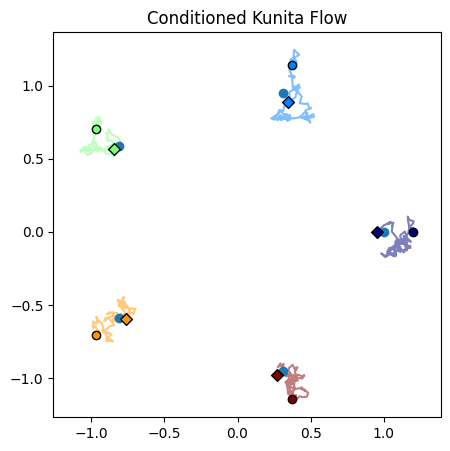

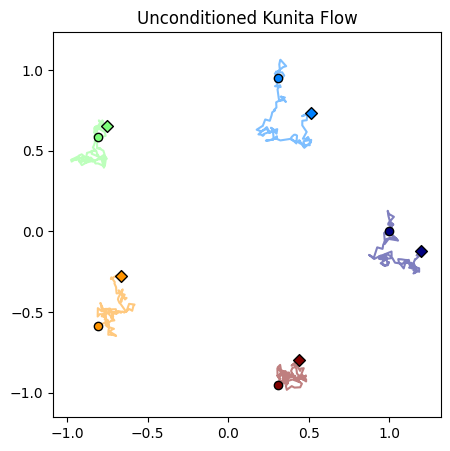

In [14]:
traj = backward_trajs[0]
plot_single_trajectory(traj, "Conditioned Kunita Flow")
plt_target = target.reshape((num_pts, 2))
plt.scatter(plt_init[:, 0], plt_init[:, 1])
traj = forward_trajs[0]
plot_single_trajectory(traj, "Unconditioned Kunita Flow")